<a id='toc'></a>
# Анализ сервиса для чтения книг по подписке

**Цель исследования**

Коронавирус застал мир врасплох, изменив привычный порядок вещей. В свободное время жители городов больше не 
выходят на улицу, не посещают кафе и торговые центры. Зато стало больше времени для книг. 

Это заметили стартаперы — и бросились создавать приложения для тех, кто любит читать.

Наша компания решила быть на волне и купила крупный сервис для чтения книг по подписке. 

Необходимо проанализировать базу данных сервиса и сформулировать ценностное предложение для нового продукта.

**Описание данных**

Мы будем работать с данными из следующих таблиц:
- таблица **books** cодержит данные о книгах:
  - book_id - идентификатор книги;
  - author_id - идентификатор автора; 
  - title - название книги;
  - num_pages - количество страниц;
  - publication_date - дата публикации книги;
  - publisher_id - идентификатор издателя.
  
- таблица **authors** содержит данные об авторах:
  - author_id - идентификатор автора;
  - author - имя автора.
  
- таблица **publishers** содержит данные об издательствах:
  - publisher_id - идентификатор издательства;
  - publisher - название издательства.

- таблица **ratings** содержит данные о пользовательских оценках книг:
  - rating_id - идентификатор оценки;
  - book_id - идентификатор книги;
  - username - имя пользователя, оставившего оценку;
  - rating - оценка книги.

- таблица **reviews** содержит данные о пользовательских оценках книг:
  - review_id - идентификатор обзора;
  - book_id - идентификатор книги;
  - username - имя пользователя, написавшего обзор;
  - text - текст обзора.
  
База данных содержит информацию о книгах, издательствах, авторах, а также пользовательские обзоры книг. 

О качестве данных ничего не известно. Поэтому перед исследованием данных понадобится их обзор.

**Ход исследования**

- Загрузка и базовый анализ данных:
  - импорт библиотек;
  - исследование таблиц.

- Предобработка данных:
  - проверка данных на пропуски;
  - проверка данных на дубликаты;
  - изучение уникальных значений;
  - изменений типов данных в столбцах, при необходимости.

- Исследовательский анализ данных с помощью SQL-запросов:
  - посчитаем, сколько книг вышло после 1 января 2000 года;
  - для каждой книги посчитаем количество обзоров и среднюю оценку;
  - определим издательство, которое выпустило наибольшее число книг толще 50 страниц (так мы исключим из анализа брошюры);
  - определим автора с самой высокой средней оценкой книг (учтем только книги с 50 и более оценками);
  - посчитаем среднее количество обзоров от пользователей, которые поставили больше 48 оценок.
  
- Общий вывод и рекомендации.

Далее проведем необходимые вычисления, на основании которых проанализируем данные и, таким образом, исследование пройдёт в 4 этапа:

- [Загрузка и базовый анализ данных.](#1)
- [Предобработка данных.](#2)
- [Исследовательский анализ данных.](#3)
- [Общий вывод и рекомендации.](#4) 

<a id="1"></a>
### Загрузка и базовый анализ данных

In [1]:
# Импортируем библиотеки
import pandas as pd
import sqlalchemy as sa
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import seaborn as sns
# Устанавливаем параметры
db_config = {
            'user': , # добавить имя пользователя
            'pwd': , # добавить пароль
            'host': , # добавить хост
            'port': 6432, # порт подключения
            'db':  # добавить название базы данных
            }
connection_string = 'postgresql://{user}:{pwd}@{host}:{port}/{db}'.format(**db_config)
# Сохраняем коннектор
engine = sa.create_engine(connection_string, connect_args={'sslmode':'require'})
# Чтобы выполнить SQL-запрос, пишем функцию с использованием Pandas
def get_sql_data(query:str, engine:sa.engine.base.Engine=engine) -> pd.DataFrame:
    '''Открываем соединение, получаем данные из sql, закрываем соединение'''
    with engine.connect() as con:
        return pd.read_sql(sql=sa.text(query), con = con)

In [2]:
# Формируем запрос к таблице books, выводим первые 5 строк, считаем сколько строк в таблице
query = '''
SELECT *, 
       COUNT(*) OVER() books_num_rows
FROM books
LIMIT 5;
'''
get_sql_data(query)

,book_id,author_id,title,num_pages,publication_date,publisher_id,books_num_rows
0,1,546,'Salem's Lot,594,2005-11-01,93,1000
1,2,465,1 000 Places to See Before You Die,992,2003-05-22,336,1000
2,3,407,13 Little Blue Envelopes (Little Blue Envelope...,322,2010-12-21,135,1000
3,4,82,1491: New Revelations of the Americas Before C...,541,2006-10-10,309,1000
4,5,125,1776,386,2006-07-04,268,1000


В таблице books 1000 строк.

In [3]:
# Формируем запрос к таблице books и сохраняем данные в датасет books для дальнейшего исследования
query = '''
SELECT * 
FROM books;
'''
books = get_sql_data(query)

In [4]:
# Выведем основную информацию о датасете books
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   book_id           1000 non-null   int64 
 1   author_id         1000 non-null   int64 
 2   title             1000 non-null   object
 3   num_pages         1000 non-null   int64 
 4   publication_date  1000 non-null   object
 5   publisher_id      1000 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 47.0+ KB


В датасете books 6 столбцов, 1000 строк.

Согласно документации к данным:
- book_id - идентификатор книги;
- author_id — идентификатор автора;
- title — название книги;
- num_pages — количество страниц;
- publication_date — дата публикации книги;
- publisher_id - идентификатор издателя.

В идеале надо бы поменять тип данных в столбце publication_date на datetime.

In [5]:
# Выводим статистическое описание данных по столбцу num_pages из books
display(books['num_pages'].describe())

count    1000.00000
mean      389.11100
std       229.39014
min        14.00000
25%       249.00000
50%       352.00000
75%       453.00000
max      2690.00000
Name: num_pages, dtype: float64

Минимальное количество страниц - 14, максимальное - 2690, стандарное отклонение существенно отличается от среднего, очевидно, что есть аномалии.

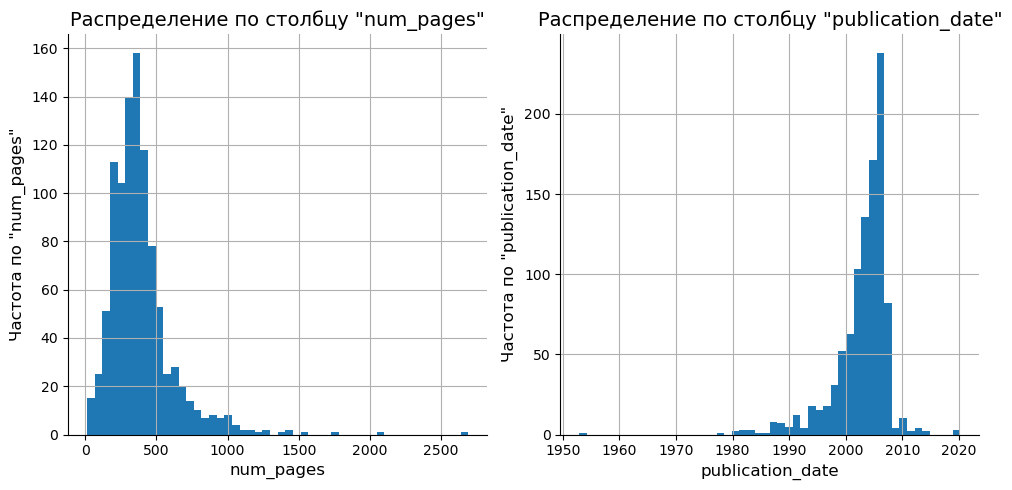

In [6]:
# Построим гистограммы для выбранных столбцов датасета books
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

selected_columns = ['num_pages', 'publication_date']

# Визуализируем данные по выбранным столбцам
for i, column_name in enumerate(selected_columns):
    books[column_name].hist(bins=50, ax=axes[i])
    axes[i].set_title(f'Распределение по столбцу "{column_name}"', fontsize=14)
    axes[i].set_xlabel(column_name, fontsize=12)
    axes[i].set_ylabel(f'Частота по "{column_name}"', fontsize=12)

sns.despine()
plt.tight_layout()

plt.show()

- На гистограмме по столбцу "num_pages" мы видим, что распределение сместилось вправо. Аномальные значения начинаются примерно после 1000 страниц, при этом больше всего книг находится в 250-480-страничном интервале;
- На гистограмме по столбцу "publication_date" мы видим, что больше всего книг издавалось в 2001-2007 годах. До 1993 и после 2008 книг издавалось мало, что создало аномалии в данных.

In [7]:
# Посмотрим на минимальную и максимальную дату публикации книг
query = '''
SELECT MIN(publication_date),
       MAX(publication_date)
FROM books;
'''
get_sql_data(query)

,min,max
0,1952-12-01,2020-03-31


In [8]:
# Формируем запрос к таблице authors, выводим первые 5 строк, считаем сколько строк в таблице
query = '''
SELECT *,
       COUNT(*) OVER() authors_num_rows
FROM authors 
LIMIT 5;
'''
get_sql_data(query)

,author_id,author,authors_num_rows
0,1,A.S. Byatt,636
1,2,Aesop/Laura Harris/Laura Gibbs,636
2,3,Agatha Christie,636
3,4,Alan Brennert,636
4,5,Alan Moore/David Lloyd,636


В таблице authors 636 строк.

In [9]:
# Формируем запрос к таблице authors и сохраняем данные в датасет authors для дальнейшего исследования
query = '''
SELECT * 
FROM authors;
'''
authors = get_sql_data(query)

In [10]:
# Выведем основную информацию о датасете authors
authors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636 entries, 0 to 635
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   author_id  636 non-null    int64 
 1   author     636 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.1+ KB


В датасете authors 2 столбца, 636 строк.

Согласно документации к данным:
- author_id — идентификатор автора;
- author - имя автора.

In [11]:
# Формируем запрос к таблице publishers, выводим первые 5 строк, считаем сколько строк в таблице
query = '''
SELECT *,
       COUNT(*) OVER() publishers_num_rows
FROM publishers 
LIMIT 5;
'''
get_sql_data(query)

,publisher_id,publisher,publishers_num_rows
0,1,Ace,340
1,2,Ace Book,340
2,3,Ace Books,340
3,4,Ace Hardcover,340
4,5,Addison Wesley Publishing Company,340


В таблице publishers 340 строк.

In [12]:
# Формируем запрос к таблице publishers и сохраняем данные в датасет publishers для дальнейшего исследования
query = '''
SELECT * 
FROM publishers;
'''
publishers = get_sql_data(query)

In [13]:
# Выведем основную информацию о датасете publishers
publishers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   publisher_id  340 non-null    int64 
 1   publisher     340 non-null    object
dtypes: int64(1), object(1)
memory usage: 5.4+ KB


В датасете publishers 2 столбца, 340 строк.

Согласно документации к данным:
- publisher_id — идентификатор издательства;
- publisher - название издательства.

In [14]:
# Формируем запрос к таблице ratings, выводим первые 5 строк, считаем сколько строк в таблице
query = '''
SELECT *,
       COUNT(*) OVER() ratings_num_rows
FROM ratings
LIMIT 5;
'''
get_sql_data(query)

,rating_id,book_id,username,rating,ratings_num_rows
0,1,1,ryanfranco,4,6456
1,2,1,grantpatricia,2,6456
2,3,1,brandtandrea,5,6456
3,4,2,lorichen,3,6456
4,5,2,mariokeller,2,6456


В таблице ratings 6456 строк.

In [15]:
# Формируем запрос к таблице ratings и сохраняем данные в датасет ratings для дальнейшего исследования
query = '''
SELECT * 
FROM ratings;
'''
ratings = get_sql_data(query)

In [16]:
# Выведем основную информацию о датасете ratings
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6456 entries, 0 to 6455
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   rating_id  6456 non-null   int64 
 1   book_id    6456 non-null   int64 
 2   username   6456 non-null   object
 3   rating     6456 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 201.9+ KB


В датасете ratings 4 столбца, 6456 строк.

Согласно документации к данным:
- rating_id — идентификатор оценки;
- book_id - идентификатор книги;
- username - имя пользователя, оставившего оценку;
- rating - оценка книги.

In [17]:
# Выводим статистическое описание данных столбца rating из ratings
display(ratings['rating'].describe())

count    6456.000000
mean        3.928284
std         0.943303
min         1.000000
25%         3.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: rating, dtype: float64

Минимальное значение в столбце - 1, максимальное - 5.

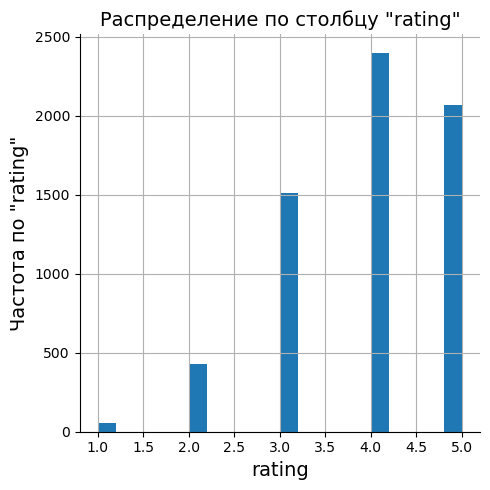

In [18]:
# Построим гистограмму для выбранного столбца датасета ratings
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

selected_columns = ['rating']

# Визуализируем данные по выбранному столбцу
for column_name in selected_columns:
    ratings[column_name].hist(bins=20, ax=axes)
    axes.set_title(f'Распределение по столбцу "{column_name}"', fontsize=14)
    axes.set_xlabel(column_name, fontsize=14)
    axes.set_ylabel(f'Частота по "{column_name}"', fontsize=14)

sns.despine()
plt.tight_layout()

plt.show()

Больше всего оценок на 4 балла.

In [19]:
# Формируем запрос к таблице reviews, выводим первые 5 строк, считаем сколько строк в таблице
query = '''
SELECT *,
       COUNT(*) OVER() reviews_num_rows
FROM reviews
LIMIT 5;
'''
get_sql_data(query)

,review_id,book_id,username,text,reviews_num_rows
0,1,1,brandtandrea,Mention society tell send professor analysis. ...,2793
1,2,1,ryanfranco,Foot glass pretty audience hit themselves. Amo...,2793
2,3,2,lorichen,Listen treat keep worry. Miss husband tax but ...,2793
3,4,3,johnsonamanda,Finally month interesting blue could nature cu...,2793
4,5,3,scotttamara,Nation purpose heavy give wait song will. List...,2793


В таблице reviews 2793 строки.

In [20]:
# Формируем запрос к таблице reviews и сохраняем данные в датасет reviews
query = '''
SELECT * 
FROM reviews;
'''
reviews = get_sql_data(query)

In [21]:
# Выведем основную информацию о датасете reviews
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2793 entries, 0 to 2792
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review_id  2793 non-null   int64 
 1   book_id    2793 non-null   int64 
 2   username   2793 non-null   object
 3   text       2793 non-null   object
dtypes: int64(2), object(2)
memory usage: 87.4+ KB


В датасете reviews 4 столбца, 2793 строки.

Согласно документации к данным:
- review_id — идентификатор обзора;
- book_id - идентификатор книги;
- username - имя пользователя, написавшего обзор;
- text - текст обзора.

**Выводы:**

На данном этапе мы:
- Подкоючились к базе данных;
- С помощью запросов к базе данных выгрузили по 5 строк каждой из 5 таблиц и посчитали сколько в них строк в целом;
- Сохранили данные в датасеты, вывели и изучили общую информацию о них;
- Минимальная дата публикации: 1952-12-01;
- Максимальная дата публикации: 2020-03-31.

Впереди предобработка данных.

[Возврат к описанию проекта](#toc)

<a id="2"></a>
### Предобработка данных

#### Объявление функций для предобработки данных

In [22]:
# Определим функцию для проверки данных на наличие явных дубликатов
def find_explicit_duplicates(dataset):
    '''
    Функция предназначена для поиска явных дубликатов в наборе данных и их отображения:
    - используется метод duplicated(), который возвращает булеву серию, указывающую на дублирующиеся строки 
    в DataFrame. Метод sum() применяется к этой серии, чтобы подсчитать общее количество дублирующихся строк. 
    Результат сохраняется в переменную explicit_duplicates_cnt;
    - функция display() используется для вывода количества явных дубликато;
    - в условии проверяется, есть ли явные дубликаты в наборе данных. Если количество явных дубликатов больше 0, 
    т.е. они есть, то выполняется следующий блок кода. Если нет, то выводится сообщение о том, что явных 
    дубликатов не найдено;
    - если дубликаты найдены, то происходит фильтрация DataFrame, которая выводит только дубликаты в результате, 
    Метод duplicated(keep=False) помогает нам выбрать все строки, которые являются дубликатами. 
    Результат сохраняется в переменную explicit_duplicates.
    Таким образом, функция возвращает количество явных дубликатов и DataFrame с явными дубликатами (если они есть).
    '''
    # Находим явные дубликаты
    explicit_duplicates_cnt = display(f'Количество явных дубликатов: {dataset.duplicated().sum()}')
    
    explicit_duplicates = None
    explicit_duplicates_cnt = 0
    
    # Выводим дубликаты в виде таблицы, если они есть
    if dataset.duplicated().sum() > 0:
        explicit_duplicates = display(dataset[dataset.duplicated(keep=False)])
    
    else:
        display('Явные дубликаты не найдены')
    
    return explicit_duplicates_cnt, explicit_duplicates

In [23]:
# Определим функцию для проверки данных на наличие неявных дубликатов
def find_implicit_duplicates(dataset, columns_to_compare):
    '''
    Функция предназначена для поиска неявных дубликатов в наборе данных на основе выбранных столбцов для сравнения:
    - используется метод duplicated(), который возвращает булеву серию, указывающую на дублирующиеся строки в 
    DataFrame. Параметр subset определяет столбцы, по которым мы хотим искать дубликаты. 
    Параметр keep=False означает, что все дубликаты будут помечены как True, а не только первый. 
    Результат сохраняется в переменную implicit_duplicates;
    - в условии проверяется, есть ли неявные дубликаты в наборе данных. Если DataFrame implicit_duplicates 
    пустой (т. е. не содержит дубликатов), то выводится сообщение о том, что неявных дубликатов нет.
    Таким образом, функция возвращает DataFrame implicit_duplicates, содержащий все неявные дубликаты 
    (если они есть). Если неявных дубликатов нет, то возвращается сообщение о их отсутствии.
    '''
    # Находим неявные дубликаты
    implicit_duplicates = dataset[dataset.duplicated(subset=columns_to_compare, keep=False)]
    if implicit_duplicates.empty:
        display('Неявных дубликатов нет.')
  
    return implicit_duplicates

In [24]:
# Определим функцию, которая будет выводить количество уникальных значений и топ-5 лист самых популярных значений
def unique_describe(dataset):
    '''
    Функция предназначена для вывода информации о количестве уникальных значений для каждого столбца в 
    наборе данных:
    - вычисляется количество уникальных значений в каждом столбце DataFrame. Результат выводится 
    с помощью функции display();
    - метод value_counts() вычисляет частоту встречаемости каждого уникального значения в столбцах DataFrame
    и выводит самые часто встречающиеся значения. Метод head() используется для вывода только первых 5
    строк результата. Результаты выводятся с помощью функции display().
    Таким образом, функция возвращает все три вышеупомянутых выражения в одном вызове функции display().
    '''
    return display(f'Количество уникальных значений: {len(dataset.unique())}',
                    dataset.value_counts().head())   

#### Изменение типов данных в столбцах

In [25]:
# Изменим тип данных в столбце publication_date датасета books на datetime
books['publication_date'] = pd.to_datetime(books['publication_date'])

#### Проверим пропуски в датасетах

In [26]:
# Создадим копию датасетов до преобразований
temp1 = books.copy() 
display(f'books: {len(temp1)}')
temp2 = authors.copy() 
display(f'authors: {len(temp2)}')
temp3 = publishers.copy() 
display(f'publishers: {len(temp3)}')
temp4 = ratings.copy() 
display(f'ratings: {len(temp4)}')
temp5 = reviews.copy() 
display(f'reviews: {len(temp5)}')

'books: 1000'

'authors: 636'

'publishers: 340'

'ratings: 6456'

'reviews: 2793'

In [27]:
# Выведем количество пропущенных значений для датасета books
books.isna().sum().sort_values()

book_id             0
author_id           0
title               0
num_pages           0
publication_date    0
publisher_id        0
dtype: int64

In [28]:
# Выведем количество пропущенных значений для датасета authors
authors.isna().sum().sort_values()

author_id    0
author       0
dtype: int64

In [29]:
# Выведем количество пропущенных значений для датасета publishers
publishers.isna().sum().sort_values()

publisher_id    0
publisher       0
dtype: int64

In [30]:
# Выведем количество пропущенных значений для датасета ratings
ratings.isna().sum().sort_values()

rating_id    0
book_id      0
username     0
rating       0
dtype: int64

In [31]:
# Выведем количество пропущенных значений для датасета reviews
reviews.isna().sum().sort_values()

review_id    0
book_id      0
username     0
text         0
dtype: int64

Пропусков в наших датасетах не обнаружено.

#### Изучим дубликаты  в датасете

In [32]:
# Проверим явные дубликаты в датасете books
dataset = books
find_explicit_duplicates(dataset)

'Количество явных дубликатов: 0'

'Явные дубликаты не найдены'

(0, None)

In [33]:
# Проверим неявные дубликаты в датасете books
dataset = books
columns_to_compare = ['title', 'num_pages']
find_implicit_duplicates(dataset.sort_values(by='num_pages'), columns_to_compare)

'Неявных дубликатов нет.'

,book_id,author_id,title,num_pages,publication_date,publisher_id


In [34]:
# Проверим явные дубликаты в датасете authors
dataset = authors
find_explicit_duplicates(dataset)

'Количество явных дубликатов: 0'

'Явные дубликаты не найдены'

(0, None)

In [35]:
# Проверим явные дубликаты в датасете publishers
dataset = publishers
find_explicit_duplicates(dataset)

'Количество явных дубликатов: 0'

'Явные дубликаты не найдены'

(0, None)

In [36]:
# Проверим явные дубликаты в датасете ratings
dataset = ratings
find_explicit_duplicates(dataset)

'Количество явных дубликатов: 0'

'Явные дубликаты не найдены'

(0, None)

In [37]:
# Проверим неявные дубликаты в датасете ratings
dataset = ratings
columns_to_compare = ['book_id', 'username']
find_implicit_duplicates(dataset.sort_values(by='book_id'), columns_to_compare)

'Неявных дубликатов нет.'

,rating_id,book_id,username,rating


In [38]:
# Проверим явные дубликаты в датасете reviews
dataset = reviews
find_explicit_duplicates(dataset)

'Количество явных дубликатов: 0'

'Явные дубликаты не найдены'

(0, None)

In [39]:
# Проверим неявные дубликаты в датасете reviews
dataset = reviews
columns_to_compare = ['book_id', 'username']
find_implicit_duplicates(dataset.sort_values(by='book_id'), columns_to_compare)

'Неявных дубликатов нет.'

,review_id,book_id,username,text


Явные и неявные дубликаты не обнаружены.

#### Изучим уникальные значения в столбцах

In [40]:
# Проанализируем данные столбца title датасета books
dataset = books['title']
unique_describe(dataset)

'Количество уникальных значений: 999'

title
Memoirs of a Geisha                                      2
'Salem's Lot                                             1
The Catcher in the Rye                                   1
The Botany of Desire: A Plant's-Eye View of the World    1
The Bourne Identity (Jason Bourne  #1)                   1
Name: count, dtype: int64

Видим книгу, напечатанную дважды. Посмотрим на эти данные.

In [41]:
query = '''
SELECT * 
FROM books
WHERE title = 'Memoirs of a Geisha';
'''
get_sql_data(query)

,book_id,author_id,title,num_pages,publication_date,publisher_id
0,426,39,Memoirs of a Geisha,434,2005-11-15,241
1,427,39,Memoirs of a Geisha,503,2005-11-22,311


Это не дубликат, книга напечатана в разных издательствах с разным количеством страниц.

In [42]:
# Проанализируем данные столбца num_pages датасета books
dataset = books['num_pages']
unique_describe(dataset)

'Количество уникальных значений: 454'

num_pages
288    21
320    18
368    18
400    15
240    13
Name: count, dtype: int64

На первый взгляд, ничего необычного в данных нет.

In [43]:
# Проанализируем данные столбца publication_date датасета books
dataset = books['publication_date']
unique_describe(dataset)

'Количество уникальных значений: 618'

publication_date
2006-08-29    10
2004-06-01    10
2006-09-26     9
2006-04-25     8
2004-08-31     8
Name: count, dtype: int64

In [44]:
# Посмотрим на первую дату в списке поближе
query = '''
SELECT * 
FROM books
WHERE publication_date = '2006-08-29';
'''
get_sql_data(query)

,book_id,author_id,title,num_pages,publication_date,publisher_id
0,11,130,A Breath of Snow and Ashes (Outlander #6),980,2006-08-29,83
1,162,434,Coraline,162,2006-08-29,333
2,249,251,Flags of Our Fathers,382,2006-08-29,35
3,448,452,Morrigan's Cross (Circle Trilogy #1),321,2006-08-29,164
4,484,127,Odd Thomas (Odd Thomas #1),446,2006-08-29,35
5,490,633,On Beauty,445,2006-08-29,212
6,594,430,Stardust,248,2006-08-29,129
7,773,159,The Known World,388,2006-08-29,14
8,818,291,The Pact,512,2006-08-29,28
9,954,572,Vanish (Rizzoli & Isles #5),401,2006-08-29,33


Одно издательство в один день выпустило 2 книги, но, в целом, также ничего необычного, такое бывает.

In [45]:
# Проанализируем данные столбца author датасета authors
dataset = authors['author']
unique_describe(dataset)

'Количество уникальных значений: 636'

author
A.S. Byatt                    1
Neal Stephenson/Guy Abadia    1
Mitch Albom                   1
Naomi Novik                   1
Napoleon Hill                 1
Name: count, dtype: int64

Ни одного повторяющегося автора!

In [46]:
# Проанализируем данные столбца publisher датасета publishers
dataset = publishers['publisher']
unique_describe(dataset)

'Количество уникальных значений: 340'

publisher
Ace                                                1
Plaza y Janés                                      1
Princeton University Press                         1
Prestwick House - (Literary Touchstone Classic)    1
Pocket Star                                        1
Name: count, dtype: int64

Ни одного повторяющегося издательства!

In [47]:
# Проанализируем данные столбца username датасета ratings
dataset = ratings['username']
unique_describe(dataset)

'Количество уникальных значений: 160'

username
martinadam        56
paul88            56
richard89         55
sfitzgerald       55
jennifermiller    53
Name: count, dtype: int64

О, ну тут явно есть очень активные пользователи, часто ставящие оценки.

In [48]:
# Проанализируем данные столбца rating датасета ratings
dataset = ratings['rating']
unique_describe(dataset)

'Количество уникальных значений: 5'

rating
4    2396
5    2067
3    1509
2     431
1      53
Name: count, dtype: int64

Рейтинги у нас в диапазоне от 1 до 5 в формате целых чисел.

In [49]:
# Проанализируем данные столбца username датасета reviews
dataset = reviews['username']
unique_describe(dataset)

'Количество уникальных значений: 160'

username
susan85        29
sfitzgerald    28
martinadam     27
eallen         26
lesliegibbs    26
Name: count, dtype: int64

Активных любителей писать отзывы тоже достаточно.

In [50]:
# Проанализируем данные столбца text датасета reviews
dataset = reviews['text']
unique_describe(dataset)

'Количество уникальных значений: 2793'

text
Mention society tell send professor analysis. Over provide race technology continue these.                                                                    1
Have leg other.                                                                                                                                               1
Outside key talk live talk born wish a. Mouth open reason avoid. Institution hundred ask personal suddenly hard care. Politics safe order newspaper point.    1
Change forward during current. Writer ready police get those those out letter.                                                                                1
House attention side front. Interview force party sign. Food who glass figure audience. Player style herself property.                                        1
Name: count, dtype: int64

Отзывы все уникальны.

In [51]:
# Сверяем наши данные по количеству строк по окончанию обработки данных в датасете.
a, b = len(temp1), len(books)
print('books:', len(temp1), len(books), round((a - b) / a * 100, 2))
a, b = len(temp2), len(authors)
print('authors:', len(temp2), len(authors), round((a - b) / a * 100, 2))
a, b = len(temp3), len(publishers)
print('publishers:', len(temp3), len(publishers), round((a - b) / a * 100, 2))
a, b = len(temp4), len(ratings)
print('ratings:', len(temp4), len(ratings), round((a - b) / a * 100, 2))
a, b = len(temp5), len(reviews)
print('reviews:', len(temp5), len(reviews), round((a - b) / a * 100, 2))

books: 1000 1000 0.0
authors: 636 636 0.0
publishers: 340 340 0.0
ratings: 6456 6456 0.0
reviews: 2793 2793 0.0


**Вывод:**

В рамках этапа предобработки данных были проведены следующие проверки:
- Данные в датасетах были проверены на пропуски, пропуски не найдены;
- Данные проверены на наличие дубликатов. Явные и неявные дубликаты отсутствуют;
- Изучены уникальные значения в стобцах. В таблице books обнаружили, что книга "Memoirs of a Geisha" была напечатана дважды, но разными издательствами;
- Изменили тип данных в столбце publication_date датасета books.

[Возврат к описанию проекта](#toc)

<a id="3"></a>
### Исследовательский анализ данных

#### Посчитаем, сколько книг вышло после 1 января 2000 года

In [52]:
# Формируем запрос для подсчета количества книг вышедших после 1 января 2000 года
query = '''
SELECT COUNT(title) cnt_books
FROM books
WHERE publication_date >='2000-01-01';
'''
after_2000 = get_sql_data(query)
after_2000

,cnt_books
0,821


После 1 января 2000 года вышла большая часть книг по сравнению с предыдущим периодом - 821.

In [53]:
# Формируем запрос для подсчета количества книг вышедших до 1 января 2000 года
query = '''
SELECT COUNT(title) cnt_books
FROM books
WHERE publication_date < '2000-01-01';
'''
before_2000 = get_sql_data(query)
before_2000

,cnt_books
0,179


Визуализируем распределение количества книг в разные годы.

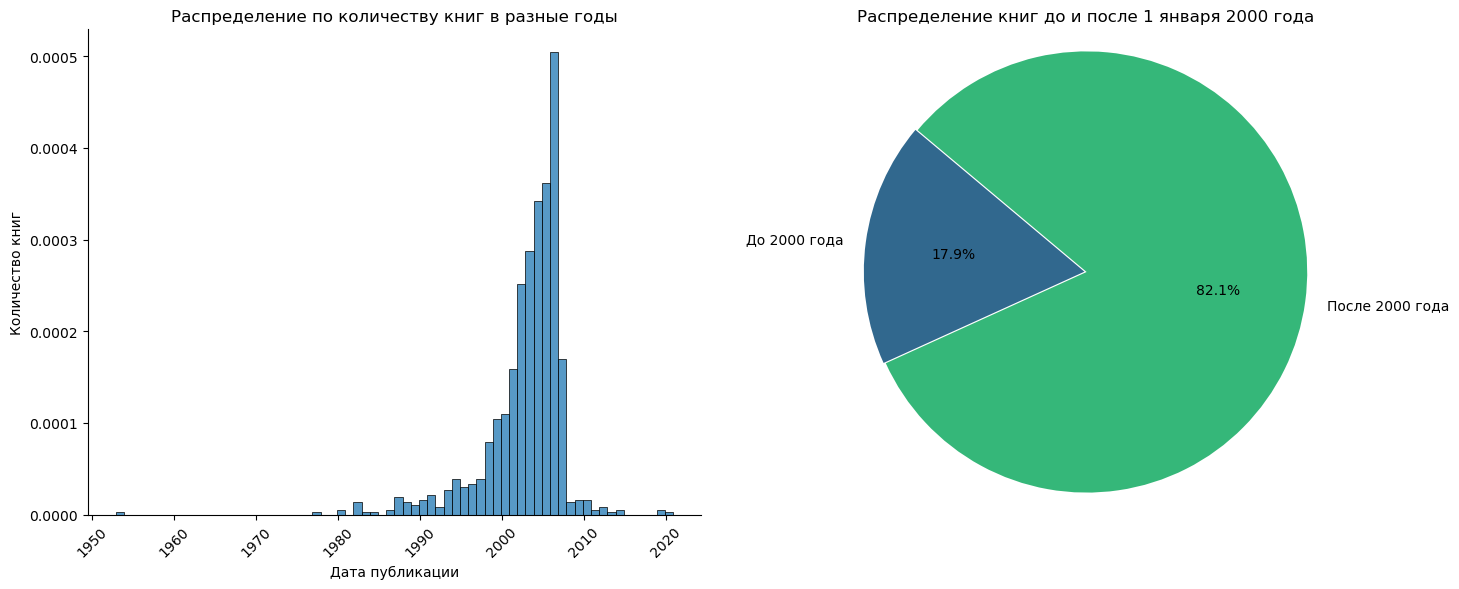

In [54]:
# Создаем фигуру с двумя осями
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Визуализируем распределение по количеству книг в разные годы с помощью гистограммы
sns.histplot(data=books, x='publication_date', binwidth=365, kde=False, ax=axes[0], common_norm=False, 
             stat='density')
axes[0].set_xlabel('Дата публикации')
axes[0].set_ylabel('Количество книг')
axes[0].set_title('Распределение по количеству книг в разные годы')
axes[0].tick_params(axis='x', rotation=45)
sns.despine(ax=axes[0])

# Данные о количестве книг до и после 2000 года
before_2000_count = before_2000['cnt_books'][0]
after_2000_count = after_2000['cnt_books'][0]

# Создаем список с данными и метками
labels = ['До 2000 года', 'После 2000 года']
counts = [before_2000_count, after_2000_count]

# Определяем цвета
colors = sns.color_palette("viridis", len(labels))

# Строим круговую диаграмму с распределением количества книг до 1 января 2000 года и после
axes[1].pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, explode=(0.01, 0), colors=colors)
axes[1].set_title('Распределение книг до и после 1 января 2000 года')
axes[1].axis('equal')

# Убираем лишние оси и метки
axes[1].set_ylabel('')
axes[1].tick_params(axis='y', which='both', left=False, labelleft=False)

plt.tight_layout()
plt.show()

Более 82% всех книг было издано после 1 января 2000 года. Самый продуктивный год по изданию книг - 2007.

#### Посчитаем количество обзоров и среднюю оценку для каждой книги

In [55]:
# Формируем запрос для подсчета количества обзоров и средней оценки для каждой книги
query = '''
SELECT b.title books,
       b.book_id,
       COUNT(DISTINCT rev.review_id) cnt_reviews,
       AVG(r.rating) avg_rating
FROM books b
LEFT JOIN reviews rev ON rev.book_id=b.book_id
LEFT JOIN ratings r ON r.book_id=b.book_id
GROUP BY b.title, b.book_id
ORDER BY cnt_reviews DESC;
'''
books_rev_rat = get_sql_data(query)
books_rev_rat

,books,book_id,cnt_reviews,avg_rating
0,Twilight (Twilight #1),948,7,3.662500
1,Water for Elephants,963,6,3.977273
2,The Glass Castle,734,6,4.206897
3,Harry Potter and the Prisoner of Azkaban (Harr...,302,6,4.414634
4,The Curious Incident of the Dog in the Night-Time,695,6,4.081081
...,...,...,...,...
995,Anne Rice's The Vampire Lestat: A Graphic Novel,83,0,3.666667
996,The Natural Way to Draw,808,0,3.000000
997,The Cat in the Hat and Other Dr. Seuss Favorites,672,0,5.000000
998,Essential Tales and Poems,221,0,4.000000


Визуализируем распределение для подсчета количества обзоров и средней оценки для каждой книги.

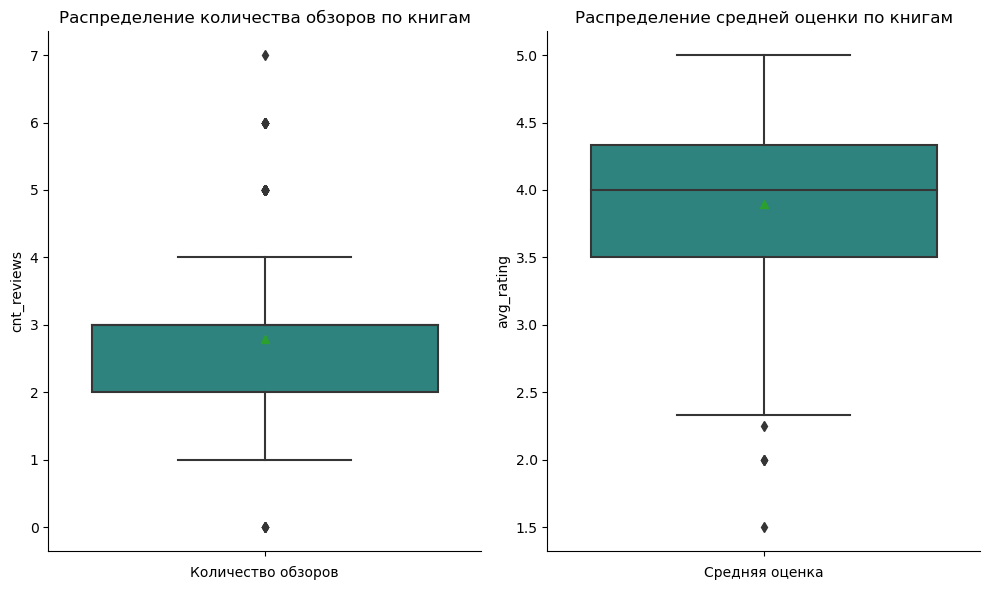

In [56]:
# Создаем фигуру с двумя осями
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

# Визуализируем распределение по количеству обзоров для всех книг с помощью боксплота
sns.boxplot(y=books_rev_rat['cnt_reviews'], palette='viridis', ax=axes[0], showmeans=True)
axes[0].set_xlabel('Количество обзоров')
axes[0].set_title('Распределение количества обзоров по книгам')

# Визуализируем распределение по средней оценке для всех книг с помощью боксплота
sns.boxplot(y=books_rev_rat['avg_rating'], palette='viridis', ax=axes[1], showmeans=True)
axes[1].set_xlabel('Средняя оценка')
axes[1].set_title('Распределение средней оценки по книгам')

sns.despine()
plt.tight_layout()
plt.show()

- В среднем на книгу приходится 2-3 обзора, после 4-х  - мы видим аномальные значения;
- Средняя оценка книги лежит в диапазоне от 3.5 до 4.4. Рейтинг меньше 2.4 - аномален.

#### Определим издательство, которое выпустило наибольшее число книг толще 50 страниц (тем самым, исключим из анализа брошюры)

In [57]:
# Формируем запрос для определения издательства, которое выпустило наибольшее число книг толще 50 страниц
query = '''
WITH 
tab AS
(SELECT COUNT(DISTINCT b.book_id) cnt_books, 
       p.publisher_id,
       p.publisher
FROM books b
JOIN publishers p ON p.publisher_id=b.publisher_id
WHERE num_pages>50
GROUP BY p.publisher_id, p.publisher
ORDER BY cnt_books DESC
LIMIT 1)

SELECT publisher_id,
       publisher
FROM tab;
'''
get_sql_data(query)

,publisher_id,publisher
0,212,Penguin Books


Итак, издательство, которое выпустило наибольшее число книг толще 50 страниц - это "Penguin Books".

In [58]:
# Сделаем срез по данному издательству и создадим новый столбец, содержащий только год публикации, сгруппируем
# по году публикации и посчитаем количество опубликованных книг за каждый год и общую сумму публикаций 
query = '''
WITH 
tab AS
(SELECT *,
       CAST(EXTRACT(YEAR FROM publication_date) AS INTEGER) publication_year
FROM books
WHERE publisher_id = 212)

SELECT publication_year, 
       COUNT(publisher_id) publisher_id,
       (SELECT COUNT(*) FROM tab) total_books
FROM tab
GROUP BY publication_year;
'''
penguin_year = get_sql_data(query)
penguin_year

,publication_year,publisher_id,total_books
0,1994,1,42
1,2000,1,42
2,2005,5,42
3,2003,11,42
4,2007,1,42
5,2002,6,42
6,2004,2,42
7,2006,8,42
8,2001,2,42
9,1999,4,42


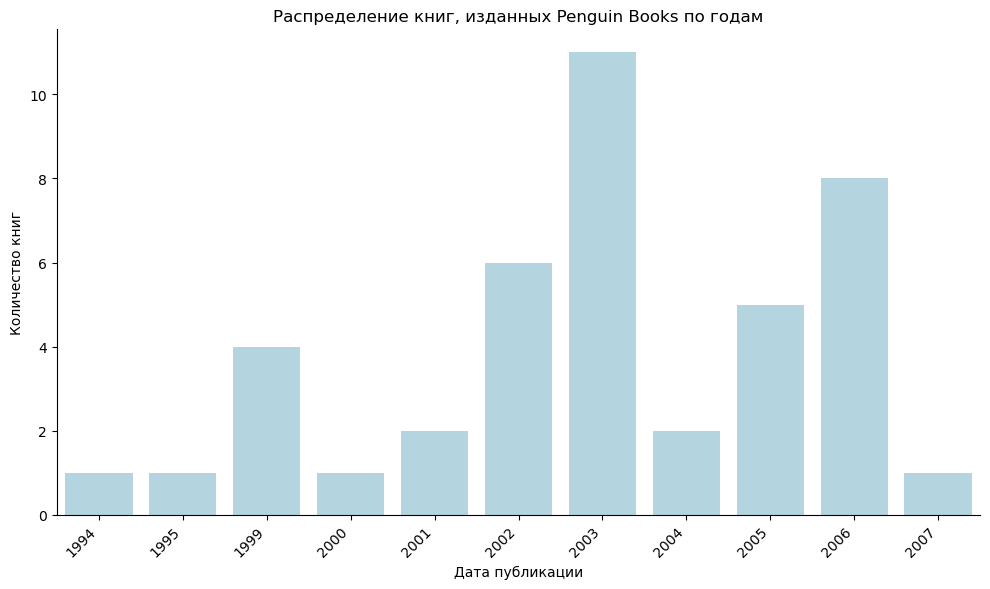

In [59]:
# Визуализируем распределение книг по датам
plt.figure(figsize=(10, 6))
sns.barplot(data=penguin_year.sort_values(by='publication_year'), x='publication_year', y='publisher_id', 
            color='lightblue')
plt.xlabel('Дата публикации')
plt.ylabel('Количество книг')
plt.title('Распределение книг, изданных Penguin Books по годам')
plt.xticks(rotation=45, ha='right')

sns.despine()
plt.tight_layout()

plt.show()

42 книги было выпущено издательством "Penguin Books" в период с 1994 по 2007 годы. Максимальное количество было выпущено в 2003 году - 11 штук.

#### Определим автора с самой высокой средней оценкой книг (будем учитывать книги только с 50 и более оценками)

In [60]:
# Формируем запрос для определения автора с самой высокой средней оценкой книг (>=50)
query = '''
WITH 
tab AS 
(SELECT book_id
FROM ratings
GROUP BY book_id
HAVING COUNT(*) >= 50)

SELECT a.author_id,
       a.author,
       AVG(r.rating) AS avg_rating
FROM books b
JOIN authors a ON b.author_id = a.author_id
JOIN ratings r ON b.book_id = r.book_id
JOIN tab ON b.book_id = tab.book_id
GROUP BY a.author_id, a.author
ORDER BY avg_rating DESC
LIMIT 1;
'''
get_sql_data(query)

,author_id,author,avg_rating
0,236,J.K. Rowling/Mary GrandPré,4.287097


Автор с самой высокой средней оценкой книги (при условии, что оценок 50 и более) - Джоан Роулинг. Посмотрим, какая книга самая популярная по рейтингам.

In [61]:
query = '''
WITH
tab AS
(SELECT book_id
FROM ratings
GROUP BY book_id
HAVING COUNT(*) >= 50),

tab1 AS
(SELECT b.book_id,
        b.title,
        b.publication_date
FROM books b
WHERE b.author_id = 236)

SELECT tab1.title, 
       tab1.publication_date,
       AVG(r.rating) AS avg_rating
FROM tab1
JOIN ratings r ON tab1.book_id = r.book_id
JOIN tab ON tab1.book_id = tab.book_id
GROUP BY tab1.title, tab1.publication_date
ORDER BY avg_rating DESC
LIMIT 1;
'''
get_sql_data(query)


,title,publication_date,avg_rating
0,Harry Potter and the Prisoner of Azkaban (Harr...,2004-05-01,4.414634


И это третья часть саги о Гарри Поттере - "Гарри Поттер и узник Азкабана", вышедшая в печать в 2004 году.

#### Посчитаем среднее количество обзоров от пользователей, которые поставили больше 48 оценок

In [62]:
# Формируем запрос для определения среднего количества обзоров от пользователей, которые поставили больше 48 оценок
query = '''
WITH
tab AS
(SELECT username
FROM ratings 
GROUP BY username
HAVING COUNT(*)>48),

tab1 AS
(SELECT tab.username,
        COUNT(rev.review_id) cnt_review
FROM reviews rev
JOIN tab ON tab.username=rev.username
GROUP BY tab.username)

SELECT AVG(cnt_review) avg_review
FROM tab1;
'''
get_sql_data(query)

,avg_review
0,24.0


Среднее количество обзоров от пользователей, поставивших более 48 оценок, составляет 24. Проверим, на всякий случай.

In [63]:
# Группируем оценки по книгам и находим тех пользователей, кто поставил больше 48 оценок
users_ratings_count = ratings.groupby('username').size().reset_index(name='rating_count')

# Отфильтровываем пользователей с более, чем 48 оценками
popular_users = users_ratings_count[users_ratings_count['rating_count'] > 48]

# Фильтруем таблицу reviews по именам пользователей из popular_name
filtered_reviews = reviews[reviews['username'].isin(popular_users['username'])]

# Группируем данные по имени пользователя, считаем количество отзывов
avg_reviews_by_user = (filtered_reviews
                        .groupby('username')
                        .agg({'review_id': 'count'})
                        .reset_index()
                        .rename(columns={'review_id': 'reviews_count'}))
# Найдем среднее количество отзывов
avg_reviews_count = avg_reviews_by_user['reviews_count'].mean()
avg_reviews_count

24.0

[Возврат к описанию проекта](#toc)

<a id="4"></a>
### Общий вывод

Мы проанализировали  данные сервиса для чтения книг по подписке с целью формирования ценностного предложения для нового продукта.

***Исследование состояло из следующих этапов:***

- ***Загрузка и базовый анализ данных:***
  - подкоючились к базе данных;
  - с помощью запросов к базе данных выгрузили по 5 строк каждой из 5 таблиц и посчитали сколько в них строк в целом;
  - сохранили данные в датасеты, вывели и изучили общую информацию о них;
  - минимальная дата публикации: 1952-12-01;
  - максимальная дата публикации: 2020-03-31.
  
- ***Предобработка данных:***
  - данные в датасетах были проверены на пропуски, пропуски не найдены;
  - данные проверены на наличие дубликатов. Явные и неявные дубликаты отсутствуют;
  - изучены уникальные значения в стобцах. В таблице books обнаружили, что книга "Memoirs of a Geisha" была напечатана дважды, но разными издательствами;
  - изменили тип данных в столбце publication_date датасета books.

- ***Исследовательский анализ данных:***
  - после 1 января 2000 года вышла 821 книга, что составляет 82.1% от общего числа книг в наших данных;
  - самый продуктивный год по изданию книг - 2007;
  - в среднем на книгу приходится 2-3 обзора;
  - средняя оценка книги лежит в диапазоне от 3.5 до 4.4;
  - издательство, которое выпустило наибольшее число книг толще 50 страниц - это "Penguin Books";
  - 42 книги было выпущено издательством "Penguin Books" в период с 1994 по 2007 годы. Максимальное количество было выпущено в 2003 году - 11 штук;
  - автор с самой высокой средней оценкой книги (при условии, что оценок 50 и более) - Джоан Роулинг. И это третья часть саги о Гарри Поттере - "Гарри Поттер и узник Азкабана", вышедшая в печать в 2004 году;
  - среднее количество обзоров от пользователей, поставивших более 48 оценок, составляет 24.

- ***Выводы и рекомендации:***
  - наш сервис содержит довольно устаревший ассортимент книг. Большая часть из них была выпущена до 2007 года;
  - необходимо организовать поступление новинок;
  - ориентироваться при выборе новинок можно на рейтинги книг или отзывы на них, могу предположить, что людей может заинтересовать фэнтези, сказки, что-то, позволяющее на время отвлечься от новостной "короновирусной" или другой аналогичной повестки дня.